In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from financepy.utils import *
from financepy.products.rates import *
from financepy.utils.day_count import DayCount, DayCountTypes
import financepy.products.rates.ibor_curve_risk_engine as re
from financepy.market.curves import *
import pickle
from datetime import timedelta
%matplotlib widget
%matplotlib auto

####################################################################
# FINANCEPY BETA Version 0.230 - This build:  03 Mar 2024 at 16:11 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################

Using matplotlib backend: module://ipympl.backend_nbagg


In [2]:
# open the pickel file curves.pkl and df_yield.pkl
with open('curves.pkl', 'rb') as f:
    curves = pickle.load(f)
with open('df_yield.pkl', 'rb') as f:
    df_yield = pickle.load(f)
df_yield = df_yield.astype(np.float32)

In [3]:
# convert outwright yield to change in yield
df_changes = df_yield.diff()
df_changes.dropna(inplace=True)
df_changes.head()

,1,2,3,4,5,6,7,8,9,10,12,15,20,25,30,40,50
Date,,,,,,,,,,,,,,,,,
2022-01-28,0.000264,0.000325,0.000290,0.000262,0.000226,0.000269,0.000226,0.000224,0.000221,0.000232,0.000279,0.000239,0.000273,0.000305,0.000346,0.000314,0.000315
2022-01-31,0.000435,0.000666,0.000699,0.000575,0.000479,0.000454,0.000460,0.000492,0.000459,0.000467,0.000537,0.000473,0.000502,0.000498,0.000512,0.000570,0.000602
2022-02-01,-0.000078,-0.000121,-0.000069,-0.000034,-0.000012,-0.000030,-0.000034,-0.000075,-0.000039,-0.000040,-0.000092,-0.000081,-0.000110,-0.000103,-0.000110,-0.000149,-0.000132
2022-02-02,-0.000130,-0.000208,-0.000260,-0.000231,-0.000213,-0.000220,-0.000236,-0.000250,-0.000260,-0.000270,-0.000288,-0.000309,-0.000370,-0.000410,-0.000450,-0.000460,-0.000495
2022-02-03,0.001779,0.001530,0.001245,0.001119,0.001068,0.001030,0.001008,0.001033,0.001041,0.000977,0.000944,0.000874,0.000835,0.000809,0.000787,0.000721,0.000673


## PCA
- use first 6m of yield curve for PCA
- we restrict to only first 20 years since we don't care the very long end of the curve

Proportion of variance explained by first 3: [0.94649681 0.04516645 0.00558786]


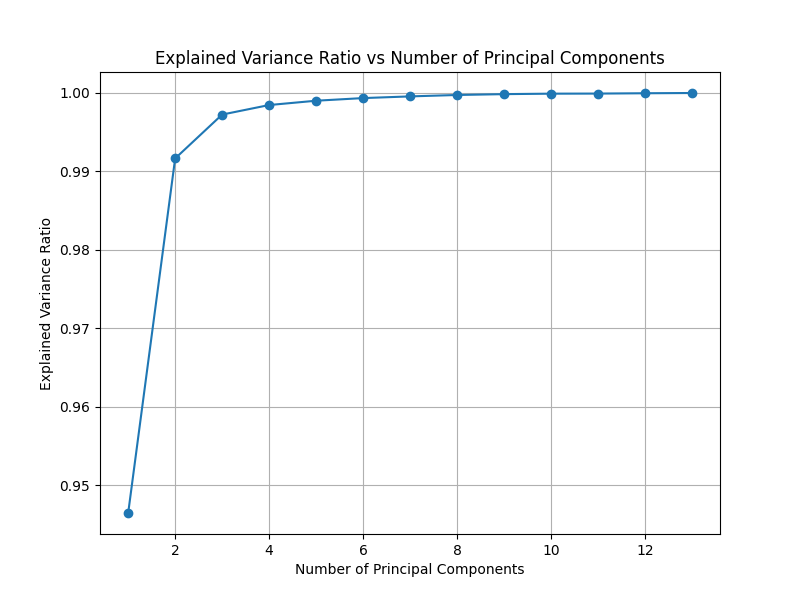

In [4]:
# PCA on first 20 years
df_PCA =  df_changes.loc[:, df_changes.columns <= 20] # only select first 20 years for PCA

df_scale = (df_PCA - df_PCA.mean(axis = 0)) / df_PCA.std(axis = 0) # standardize the data
first_date = df_scale.index[0] # first_date is a string
six_months = timedelta(days=30 * 6) # 6 months in days
end_date = first_date + six_months # Add 6 months to the original datetime
# convert end_date back to 'dd-mm-yyyy'
dates =  df_PCA.index
mask = (dates >= first_date) & (dates <= end_date) # mask for first 6 months
df_scale = df_scale[mask] # only use first 6 months of data

# conduct PCA
cov_matrix = np.cov(df_scale.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
explained_variance = eigenvalues / sum(eigenvalues)
explained_variance_ratio = explained_variance.cumsum()

# store the principle components
PC1 = df_scale.dot(eigenvectors[:,0]) # if X=U*Sigma*V^T, then PC1 = X*V[:,0] = U[:,0]*Sigma[0,0]
PC2 = df_scale.dot(eigenvectors[:,1])
PC3 = df_scale.dot(eigenvectors[:,2])

# plot explained variance ratio
print('Proportion of variance explained by first 3:',explained_variance[:3])
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Principal Components')
plt.grid()

the correlation between 1st PC and 10Y yield changes is: 0.9851168354796769


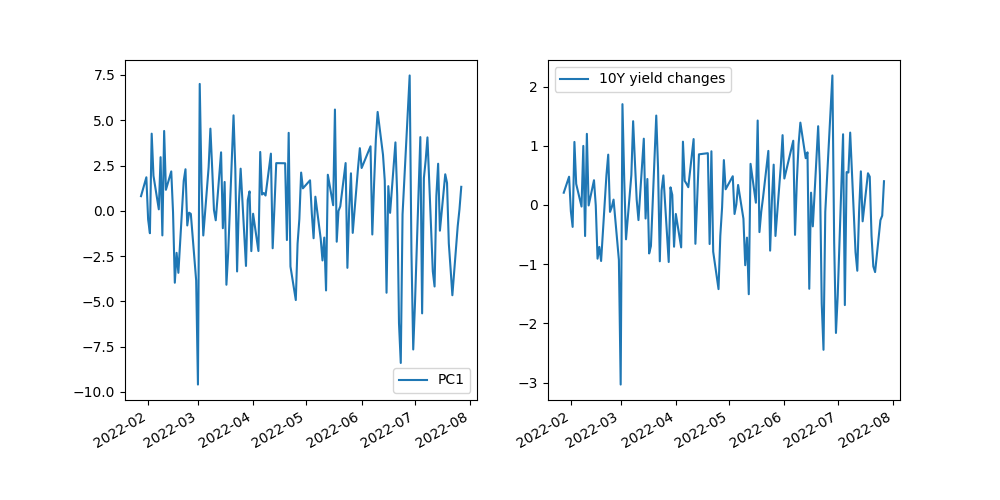

In [5]:
# get the corrlation between 1st PC and level using 10Y
print(f"the correlation between 1st PC and 10Y yield changes is: {np.corrcoef(-PC1, df_scale.loc[:,10])[0][1]}")
# 1nd PC is the level of the curve
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(dates[mask], -PC1, label='PC1')
plt.legend()
plt.subplot(1,2,2)
plt.plot(dates[mask], df_scale.loc[:,10], label='10Y yield changes')
# make the x-axis date less
plt.gcf().autofmt_xdate()
plt.legend()

the correlation between 2nd PC and 2s5s10s butterfly is: -0.12428876923470586
the correlation between 2nd PC and 5s10s20s butterfly is: -0.5884071523094149
the correlation between 2nd PC and 5s10s spread is: -0.9260210791160085
the correlation between 2nd PC and 2s10s spread is: -0.9773971806646657


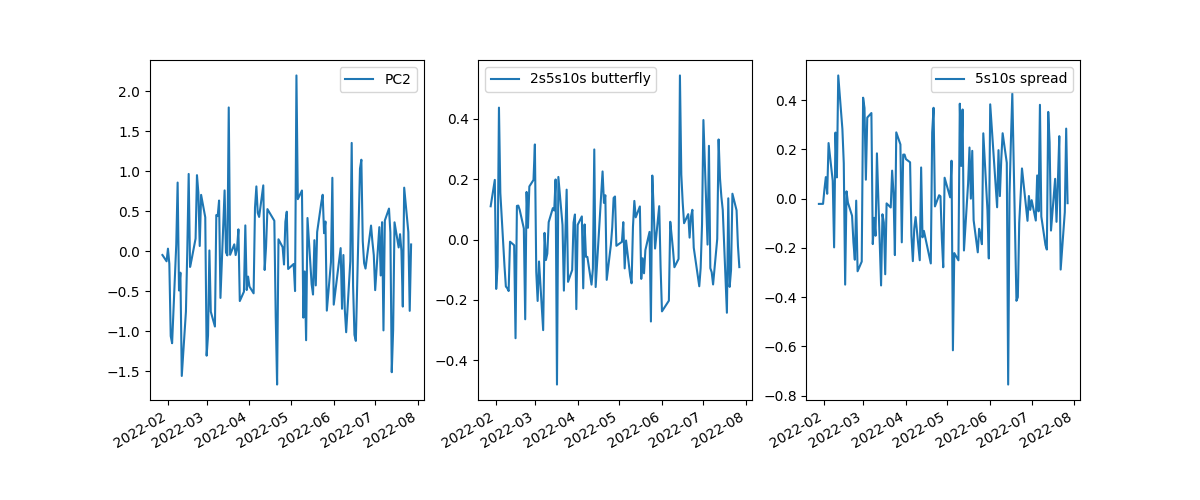

In [6]:
# 2nd PC and its correlation with curvature, slope
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(dates[mask],PC2, label='PC2')
plt.legend()
# calculate the curvature of curve changes
curvature1 = df_scale.loc[:,2] - 2*df_scale.loc[:,5] + df_scale.loc[:,10] # 2s5s10s butterfly
curvature2 = df_scale.loc[:,5] - 2*df_scale.loc[:,10] + df_scale.loc[:,20] # 5s10s20s butterfly
spread_5_10 = df_scale.loc[:,5] - df_scale.loc[:,10] # 5s10s spread
spread_2_10 = df_scale.loc[:,2] - df_scale.loc[:,10] # 2s10s spread
print(f"the correlation between 2nd PC and 2s5s10s butterfly is: {np.corrcoef(PC2, curvature1)[0][1]}")
print(f"the correlation between 2nd PC and 5s10s20s butterfly is: {np.corrcoef(PC2, curvature2)[0][1]}")
print(f"the correlation between 2nd PC and 5s10s spread is: {np.corrcoef(PC2, spread_5_10)[0][1]}")
print(f"the correlation between 2nd PC and 2s10s spread is: {np.corrcoef(PC2, spread_2_10)[0][1]}")
plt.subplot(1,3,2)
plt.plot(dates[mask],curvature1, label='2s5s10s butterfly')
plt.gcf().autofmt_xdate()
plt.legend()
plt.subplot(1,3,3)
plt.plot(dates[mask],spread_5_10, label='5s10s spread')
plt.gcf().autofmt_xdate()
plt.legend()



the correlation between 3rd PC and 2s5s10s butterfly is: 0.6636936588315
the correlation between 3rd PC and 5s10s20s butterfly is: -0.11254684243180572
the correlation between 3rd PC and 5-10 spread is: -0.30489263663868804
the correlation between 3rd PC and 2-10 spread is: -0.06524770058949983


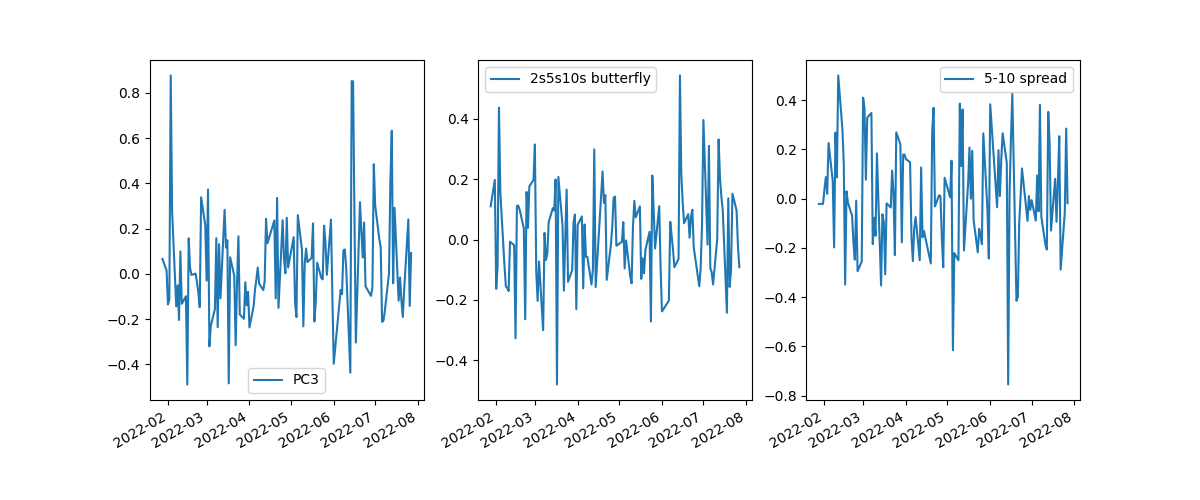

In [7]:
# 3rd PC and its correlation with 2s5s10s butterfly, 5-10 spread
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.plot(dates[mask],PC3, label='PC3')
plt.legend()
print(f"the correlation between 3rd PC and 2s5s10s butterfly is: {np.corrcoef(PC3, curvature1)[0][1]}")
print(f"the correlation between 3rd PC and 5s10s20s butterfly is: {np.corrcoef(PC3, curvature2)[0][1]}")
print(f"the correlation between 3rd PC and 5-10 spread is: {np.corrcoef(PC3, spread_5_10)[0][1]}")
print(f"the correlation between 3rd PC and 2-10 spread is: {np.corrcoef(PC3, spread_2_10)[0][1]}")
plt.subplot(1,3,2)
plt.plot(dates[mask],curvature1, label='2s5s10s butterfly')
plt.gcf().autofmt_xdate()
plt.legend()
plt.subplot(1,3,3)
plt.plot(dates[mask],spread_5_10, label='5-10 spread')
plt.gcf().autofmt_xdate()
plt.legend()



We observe a strong correlation between 2s5s10s spread and PC2, and we see that 2s5s10s spread is not strongly correlated with PC3, while 5s10s spread is resonably correlated with PC3. This become more obvious when we replace 5s10s spread with 2s10s spread. So we have strong evidence that in the first 6m, curvature is driving PC2, rather than the slope. 

## Construct Butterfly Trade (replace to 5s10s20s)
We will construct a butterfly trade using 2y,5y,10y spot swap. We long 5y swap while short 2y and 10y swap. We need to make sure the trade is immune to both level and slope of the curve.

Let $ w_{2y} $, $ w_{5y} $, and $ w_{10y} $ represent the weights for the 2-year, 5-year, and 10-year bond positions, respectively. For the purpose of these equations, we will assume $ w_{5y} = 1 $, which allow us to solve deterministically $w_{2y}$ and $w_{10y}$.

1. **DV01 Neutrality**:
   $$
   w_{2y} \cdot PV01_{2y} + w_{10y} \cdot PV01_{10y} = PV01_{5y}
   $$

2. **Slope Neutrality**:
   $$
   w_{2y} \cdot (PV01_{5y} - PV01_{2y}) - w_{10y} \cdot (PV01_{10y} - PV01_{5y}) = 0
   $$
We can represent the problem as a linear system below:
$$
\begin{bmatrix}
PV01_{2y} & PV01_{10y} \\
PV01_{2y} - PV01_{5y} & PV01_{10y} - PV01_{5y}
\end{bmatrix}
\begin{bmatrix}
w_{2y} \\
w_{10y}
\end{bmatrix}
=
\begin{bmatrix}
PV01_{5y} \\
0
\end{bmatrix}
$$

This matrix representation encapsulates the system of equations that needs to be solved to find the weights \( w_{2y} \) and \( w_{10y} \) that make the butterfly trade immune to both parallel shifts and slope changes in the yield curve.

In [8]:
# some parameters
trade_date =  df_yield.index[df_yield.index>end_date][0] # trade from first available date after 6m
day, month, year = trade_date.day, trade_date.month, trade_date.year
valuation_date = Date(day, month, year)
spot_days = 0
settlement_date = valuation_date.add_weekdays(spot_days)
fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.ACT_365F # 365 fixed
cal = CalendarTypes.UNITED_KINGDOM # calendar type
curve = curves[trade_date] # curve for trade date

In [9]:
# create the 2y, 5y, 10y swaps and for solving the linear system
swap5y = IborSwap(effective_date=settlement_date, termination_date_or_tenor='5Y',
                            fixed_leg_type=SwapTypes.RECEIVE, fixed_coupon=1*gPercent, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType,
                            float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)

swap10y = IborSwap(effective_date=settlement_date, termination_date_or_tenor='10Y',
                            fixed_leg_type=SwapTypes.PAY, fixed_coupon=1*gPercent, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType,
                            float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)
swap20y = IborSwap(effective_date=settlement_date, termination_date_or_tenor='20Y',
                            fixed_leg_type=SwapTypes.RECEIVE, fixed_coupon=1*gPercent, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType,
                            float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)

# solve the linear system so that the trade is immune to level and slope
pv01_5y = swap5y.pv01(valuation_date, curve)
pv01_10y = swap10y.pv01(valuation_date, curve)
pv01_20y = swap20y.pv01(valuation_date, curve)
# set up the linear system
A = np.array([[pv01_5y, pv01_20y], [(pv01_10y-pv01_5y), -(pv01_20y - pv01_10y)]])
b = np.array([pv01_10y, 0])
ratio = np.linalg.solve(A, b) # the notional for 2y and 10y assuming 5y is 1
print(f"the ratio of the notional for the butterfly trade is: {round(ratio[0],2)}:1:{round(ratio[1],2)}")

the ratio of the notional for the butterfly trade is: 0.63:1:0.37


In [10]:
# now create the 2y, 5y, 10y swaps for the butterfly trade with correct notionals
swap5y = IborSwap(effective_date=settlement_date, termination_date_or_tenor='5Y',
                            fixed_leg_type=SwapTypes.RECEIVE, fixed_coupon=1*gPercent, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType, notional=round(ratio[0]*10000),
                            float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)

swap10y = IborSwap(effective_date=settlement_date, termination_date_or_tenor='10Y',
                            fixed_leg_type=SwapTypes.PAY, fixed_coupon=1*gPercent, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType, notional=10000,
                            float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)
swap20y = IborSwap(effective_date=settlement_date, termination_date_or_tenor='20Y',
                            fixed_leg_type=SwapTypes.RECEIVE, fixed_coupon=1*gPercent, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType, notional=round(ratio[1]*10000),
                            float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)

# set the trade to be ATM at start
swap5y.set_fixed_rate_to_atm(settlement_date,curve)
swap10y.set_fixed_rate_to_atm(settlement_date,curve)
swap20y.set_fixed_rate_to_atm(settlement_date,curve)

# store their first fixing rate as the par rate since they are ATM
ffr_5y = swap5y.get_fixed_rate()
ffr_10y = swap10y.get_fixed_rate()
ffr_20y = swap20y.get_fixed_rate()

fly_spot_5_10_20 = {
    'spot5y': swap5y,
    'spot10y': swap10y,
    'spot20y': swap20y
}

# some facts about the swaps
print("swap rate")
print(swap5y.swap_rate(valuation_date=valuation_date, discount_curve=curve))
print(swap10y.swap_rate(valuation_date=valuation_date, discount_curve=curve))
print(swap20y.swap_rate(valuation_date=valuation_date, discount_curve=curve))
# print value
print("value")
print(swap5y.value(valuation_date, curve))
print(swap10y.value(valuation_date, curve))
print(swap20y.value(valuation_date, curve))
# print pv01
print("pv01")
print(swap5y.pv01(valuation_date, curve))
print(swap10y.pv01(valuation_date, curve))
print(swap20y.pv01(valuation_date, curve))

swap rate
0.022195000647345246
0.020620999324352938
0.020901999408340494
value
-1.1368683772161603e-13
2.2737367544323206e-13
-2.2737367544323206e-13
pv01
4.671251088706468
8.916885655393763
16.20276301618166


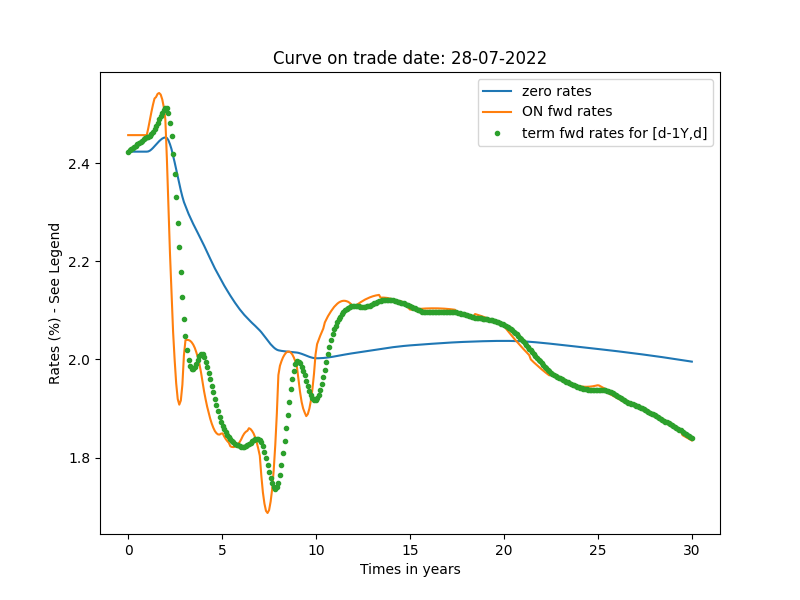

In [11]:
# plot the curve on the day we put on trade
def plotCurve(curve, start_date, tmax, instr_mat_dates_or_tenor = None, title = ''):
    """
    Plots zero rates, ON fwd rates and term fwd rates for a curve
    Inputs:
    curve: IborSingleCurve
    start_date: Date
    tmax: float, max time in years shown in the plot
    instr_mat_dates_or_tenor: None or list of Dates or a tenor string
    title: str, title of the plot
    """
    years = np.linspace(1/365, tmax, int(365*tmax)//30) # split the time into 30 day intervals
    dates = start_date.add_years(years) # the array of end dates for the curve
    zero_rates = curve.zero_rate(dates) # zero_rate
    on_fwd_rates = curve.fwd(dates) # ON fwd rates

    ys_monthly = np.arange(1,tmax*12+1)/12
    monthly_dates = start_date.add_years(ys_monthly)

    if instr_mat_dates_or_tenor is not None:
        # Will plot term forward rates
        # instr_mat_dates_or_tenor could be a list of curve-building
        # isntrument maturities in which case term fwd rates go from the last instrument maturiy date that is less
        # than the plotting date to the plotting date. Or it could be a tenor so that fwd rates cover that tenor 
        # i.e. the term fwd rate for d covers [max(d-tenor,start_date), d]
        # tenor should be a positive tenor

        if isinstance(instr_mat_dates_or_tenor, str):
            neg_tenor = '-' + instr_mat_dates_or_tenor
            start_fwd_dates = [d.add_tenor(neg_tenor) for d in dates]
            start_fwd_dates = [d if d > start_date else start_date for d in start_fwd_dates]
            fwd_rate_label = f'term fwd rates for [d-{instr_mat_dates_or_tenor},d]'
        else:
            instr_mat_dates_or_tenor = [start_date] + instr_mat_dates_or_tenor
            start_fwd_dates = [ max([md  for md in instr_mat_dates_or_tenor if md < d]) for d in dates]
            fwd_rate_label = 'term fwd rates from prev instr mtrty'

        term_fwd_rates = curve.fwd_rate(start_fwd_dates, dates)

    plt.figure(figsize=(8,6))
    plt.plot(years, zero_rates*100, '-', label="zero rates")
    plt.plot(years, on_fwd_rates*100, '-', label = "ON fwd rates")

    if instr_mat_dates_or_tenor is not None:
        plt.plot(years, term_fwd_rates*100, '.', label = fwd_rate_label)

    plt.xlabel("Times in years")
    plt.ylabel("Rates (%) - See Legend")
    plt.title(title)
    plt.legend()

plotCurve(curve, settlement_date, 30, instr_mat_dates_or_tenor = '1Y', title = f'Curve on trade date: {trade_date.strftime("%d-%m-%Y")}')

### Carry and Rolldown

In [12]:
trade_to_use = fly_spot_5_10_20
rolldown_tenor = '1Y' # rolldown tenor for carry and rolldown report
last_date = fly_spot_5_10_20['spot10y']._maturity_date # last day of the tenor
risk_res = re.carry_rolldown_report( # carry and rolldown report
    curve, grid_last_date = last_date, grid_bucket_tenor = rolldown_tenor, 
    trades = trade_to_use.values(), trade_labels=list(trade_to_use.keys()), )
df_roll = risk_res[1]

DV01:spot5y    -3.025059
DV01:spot10y    9.143776
DV01:spot20y   -6.095654
DV01:total      0.023063
dtype: float64
ROLL:spot5y    -51.852547
ROLL:spot10y    93.480737
ROLL:spot20y   -28.679123
ROLL:total      12.949067
dtype: float64


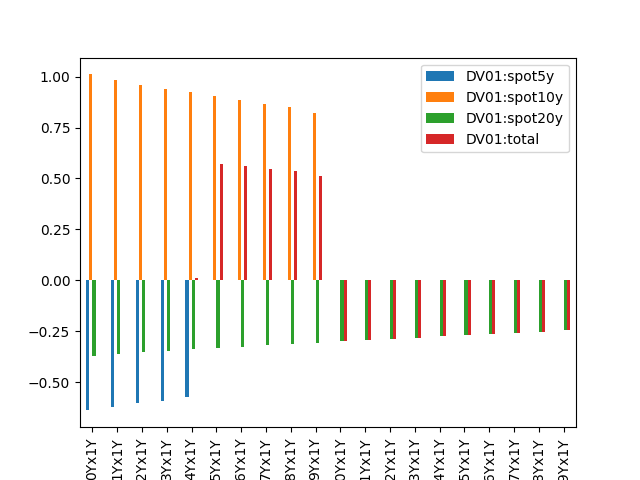

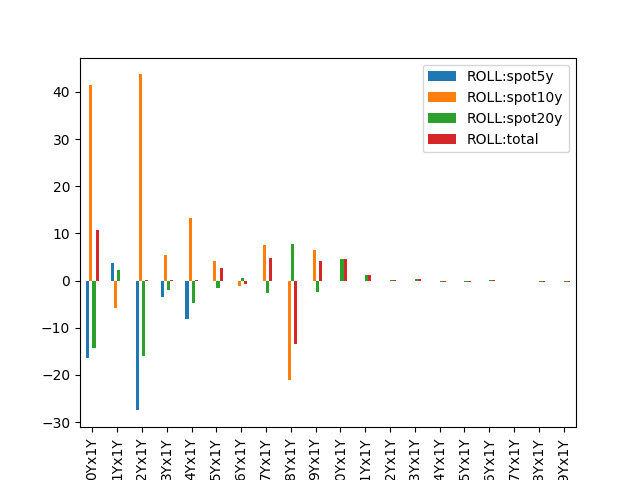

In [13]:
def plot_metric_for_strategy(curve, strategy, metric = 'DV01'):
    """
    plot metric for a strategy
    Inputs:
    curve: IborSingleCurve
    strategy: dict of IborSwap
    metric: str
    """
    rolldown_tenor = '1Y' # rolldown tenor for carry and rolldown report
    last_date = curve._usedSwaps[-1]._maturity_date
    risk_res = re.carry_rolldown_report(
    curve, grid_last_date = last_date, grid_bucket_tenor = rolldown_tenor, 
    trades = strategy.values(), trade_labels=list(strategy.keys()), )
    df_roll = risk_res[1]

    metric_cols = [c for c in df_roll.columns if c.startswith(metric)]
    nonzero_metric = (df_roll[metric_cols] != 0).any(axis = 1)
    df_metric = df_roll.loc[nonzero_metric]
    df_metric.plot.bar('bucket_label', metric_cols)

    print(df_metric[metric_cols].sum())

#Test (with somewhat convoluted way to just get first 3 outrights)
plot_metric_for_strategy(curve, fly_spot_5_10_20, metric='DV01')
plot_metric_for_strategy(curve, fly_spot_5_10_20, metric='ROLL')

## PNL calculation
- need to valuate a swap given a curve, e.g. `swap5y.value(valuation_date = valuation_date, discount_curve = curve, firstFixingRate = ffr)`
- For IborSwap, the floating leg payments are determined based on the IBOR rates fixed at the start of each interest period. We need to adjust our valuation for the floating leg after each payment date by resetting the firstfixingrate based on the LiborCurve on the payment date. For example, given a 2y swap with annual payment frequency, after the first payment, we reset the firstFixingRate as the 1y Libor rate based on the curve on the payment date.

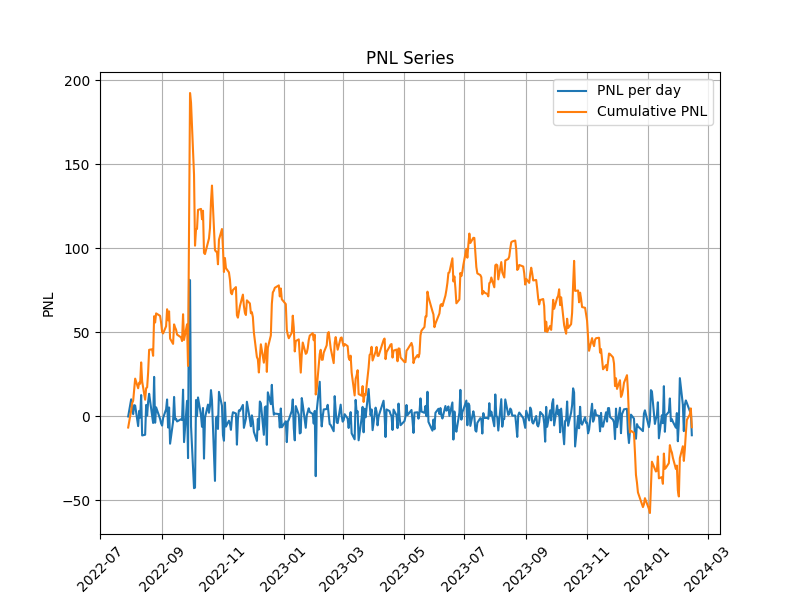

In [14]:
# calculate PNL series (probably need to change the way we calculate pnl)
# the trade date is the first date after 6m
trade_date =  df_yield.index[df_yield.index>end_date][0] # trade from first available date after 6m
day, month, year = trade_date.day, trade_date.month, trade_date.year
valuation_date = Date(day, month, year) # the initial date we want to value
spot_days = 0
settlement_date = valuation_date.add_weekdays(spot_days)
# store an array of payment dates for the trade for PnL adjustment
# since we will only cross 1 payment date, we only need first payment date
payment_dates = swap5y._float_leg._cashflow_report_from_cached_values().payment_date.values # an array of payment dates
first_payment_date = payment_dates[0] # the first payment date
post_trade_dates = df_yield.index[df_yield.index > trade_date] # dates after trade date
curve = curves[trade_date] # initialie curve
# initialize a pd series with 0 pnl for each date
trade_to_use = fly_spot_5_10_20
pnl_series = pd.Series(np.zeros(len(post_trade_dates)),index=post_trade_dates) # pnl per day
cumulative_pnl_series = pd.Series(np.zeros(len(post_trade_dates)),index=post_trade_dates) # cumulative pnl per day

# PNL calculation
for i, date in enumerate(post_trade_dates):
    day, month, year = date.day, date.month, date.year
    new_valuation_date = Date(day, month, year)
    current_curve = curves[date] # the curve on the date
    
    if new_valuation_date >= first_payment_date:
        payment_date = pd.Timestamp(first_payment_date.datetime()) # the first payment date in datetime format
        payment_date_curve = curves[payment_date] # the curve on the payment date
        ffr = payment_date_curve.swap_rate(effective_date=first_payment_date,maturity_date=first_payment_date.add_years(1))
        for swap in trade_to_use.values():
            cumulative_pnl_series[date] += swap.value(valuation_date = new_valuation_date, discount_curve=current_curve, firstFixingRate=ffr)
            if i != 0:
                pnl_series[i] = cumulative_pnl_series[i] - cumulative_pnl_series[i-1]
    else: # if the date is before first payment date, we just set ffr as par rate for each swap
        for swap in trade_to_use.values():
            # need to know which swap this is so i can put ffr, only for 2y, 5y, 10y
            if swap._maturity_date == swap5y._maturity_date:
                ffr = ffr_5y
            elif swap._maturity_date == swap10y._maturity_date:
                ffr = ffr_10y
            else:
                ffr = ffr_20y
            cumulative_pnl_series[date] += swap.value(valuation_date = new_valuation_date, discount_curve=current_curve, firstFixingRate=ffr)
            if i != 0:
                pnl_series[i] = cumulative_pnl_series[i] - cumulative_pnl_series[i-1]

plt.figure(figsize=(8,6))
plt.plot(pnl_series,label = 'PNL per day')
plt.plot(cumulative_pnl_series, label = 'Cumulative PNL')
plt.title('PNL Series')
plt.xlabel('Date')
plt.ylabel('PNL')
plt.xticks(rotation=45)
plt.legend()
plt.grid()

In [15]:
# correlation between pnl and level
print(f"correlation between pnl and 10y yield: {np.corrcoef(pnl_series, df_yield.loc[post_trade_dates,10])[0][1]}")
# correlation between pnl and slope
spread_5_10 = df_changes[10] - df_changes[5] # 10y yield - 5y yield
spread_2_10 = df_changes[10] - df_changes[2] # 10y yield - 2y yield
post_trade_spread = spread_5_10[post_trade_dates] # 5-10 spread post trade
post_trade_spread2 = spread_2_10[post_trade_dates] # 2-10 spread post trade
print(f"correlation between pnl and 5-10 spread: {np.corrcoef(pnl_series, post_trade_spread)[0][1]}")
print(f"correlation between pnl and 2-10 spread: {np.corrcoef(pnl_series, post_trade_spread2)[0][1]}")
# correlation between pnl and curvature
spread_butterfly = -ratio[0]*df_changes[5] + 1*df_changes[10] - ratio[1] * df_changes[20] # 5s10s20s butterfly, with notional 0.832 for 10y as we made it DV01 neutral
post_trade_butterfly = spread_butterfly[post_trade_dates]
print(f"correlation between pnl and 5s10s20s spread: {np.corrcoef(pnl_series, post_trade_butterfly)[0][1]}")

correlation between pnl and 10y yield: 0.017731347528462955
correlation between pnl and 5-10 spread: 0.1595986693261005
correlation between pnl and 2-10 spread: 0.2937649558708488
correlation between pnl and 5s10s20s spread: 0.5340865228595143


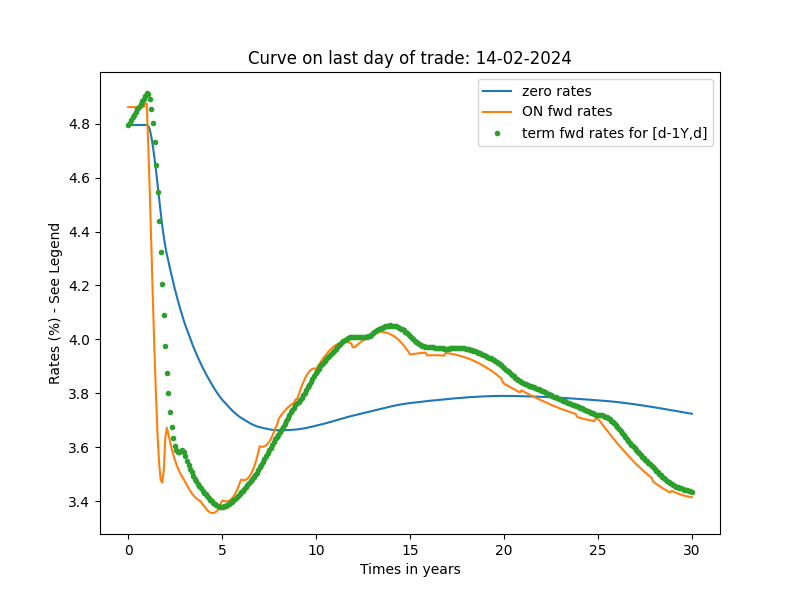

In [16]:
# plot the curve on the last day of the trade to see why pnl oscillates
last_date = df_yield.index[-1]
last_curve = curves[last_date]
day, month, year = last_date.day, last_date.month, last_date.year
last_date_ = Date(day, month, year)
plotCurve(last_curve, last_date_, 30, instr_mat_dates_or_tenor = '1Y', title = f'Curve on last day of trade: {last_date.strftime("%d-%m-%Y")}')

By straight inspection, the reason why our PnL increase then decrease is that aroung July 2023, the curve become less inverted around the 2s10s sesction, but then in Feb 2024, it become inverted again.

## PCA post trade dates
- we need to justify the butterfly trade PNL correlation with the PCs

In [17]:
# PCA on post trade dates and standardize the data
post_trade_scales = (df_PCA.loc[post_trade_dates] - df_PCA.loc[post_trade_dates].mean(axis = 0)) / df_PCA.loc[post_trade_dates].std(axis = 0) # standardize the data
cov_matrix = np.cov(post_trade_scales.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
explained_variance = eigenvalues / sum(eigenvalues)
print('Proportion of variance explained by first 3:',explained_variance[:3])

PC1 = post_trade_scales.dot(eigenvectors[:,0]) # if X=U*Sigma*V^T, then PC1 = X*V[:,0] = U[:,0]*Sigma[0,0]
PC2 = post_trade_scales.dot(eigenvectors[:,1])
PC3 = post_trade_scales.dot(eigenvectors[:,2])

Proportion of variance explained by first 3: [0.93170543 0.05764549 0.00751951]


In [18]:
# correlation between pnl and the PCs
print(f"post-trade correlation between pnl and 1st PC: {np.corrcoef(pnl_series, PC1)[0][1]}")
print(f"post-trade correlation between pnl and 2nd PC: {np.corrcoef(pnl_series, PC2)[0][1]}")
print(f"post-trade correlation between pnl and 3rd PC: {np.corrcoef(pnl_series, PC3)[0][1]}")

post-trade correlation between pnl and 1st PC: -0.3641283418001154
post-trade correlation between pnl and 2nd PC: 0.19074492756292938
post-trade correlation between pnl and 3rd PC: -0.4803199972207039


the correlation between 1st PC (post-trade) and 10Y yield is: -0.015641876644778265


Text(0.5, 0.98, 'Post-trade 1st PC vs 10Y yield')

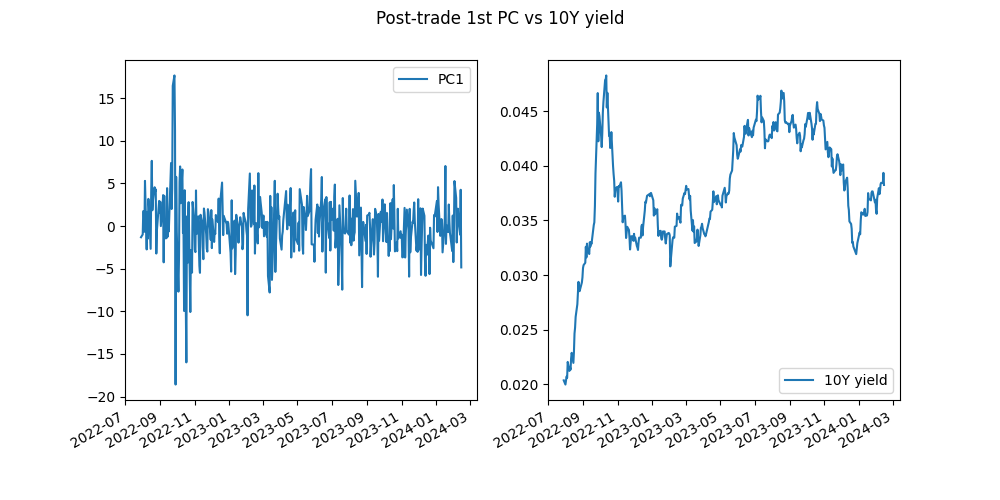

In [19]:
# plot the first PC with 10y yield
print(f"the correlation between 1st PC (post-trade) and 10Y yield is: {np.corrcoef(PC1, -df_yield.loc[post_trade_dates,10])[0][1]}")
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(post_trade_dates, -PC1, label='PC1')
plt.legend()
plt.subplot(1,2,2)
plt.plot(post_trade_dates, df_yield.loc[post_trade_dates,10], label='10Y yield')
# make the x-axis date less
plt.gcf().autofmt_xdate()
plt.legend()
# a super title
plt.suptitle('Post-trade 1st PC vs 10Y yield')


the correlation between 2nd PC (post-trade) and 5-10 spread is: 0.867508316973065
the correlation between 2nd PC (post-trade) and 5s10s20s butterfly is: 0.725839257401561
the correlation between 2nd PC (post-trade) and PnL: 0.19074492756292938


Text(0.5, 0.98, 'Post-trade 2nd PC vs 5-10 spread and 2s5s10s butterfly')

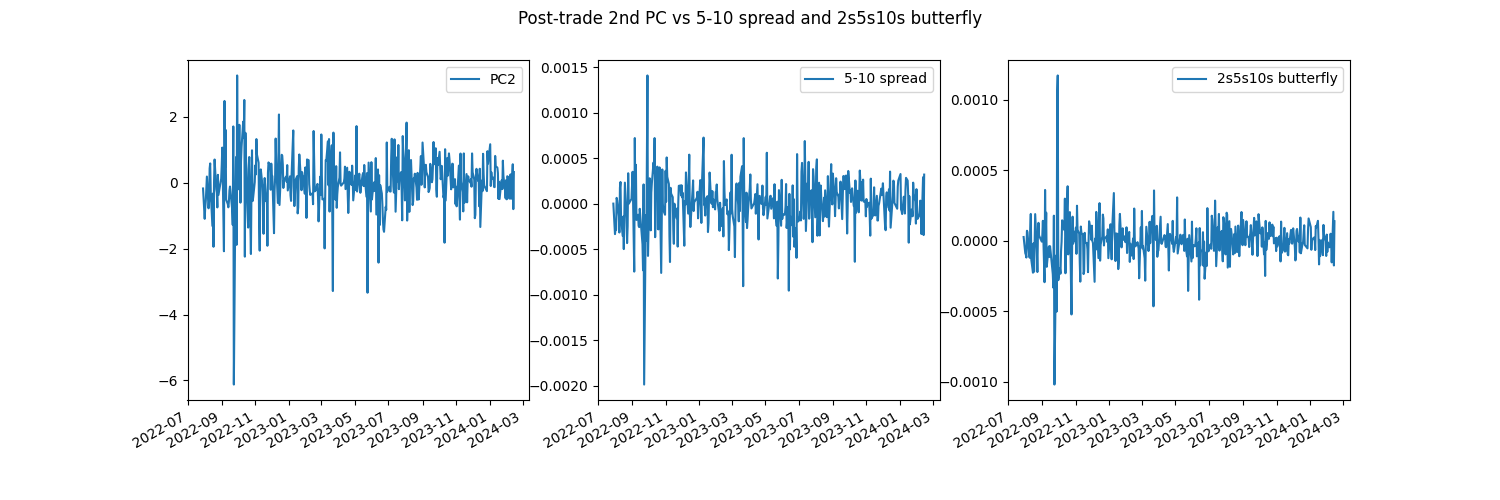

In [20]:
# plot the 2nd PC with 5-10 spread and 2s5s10s butterfly
PC2 = post_trade_scales.dot(eigenvectors[:,1])
print(f"the correlation between 2nd PC (post-trade) and 5-10 spread is: {np.corrcoef(PC2, post_trade_spread)[0][1]}")
print(f"the correlation between 2nd PC (post-trade) and 5s10s20s butterfly is: {np.corrcoef(PC2, post_trade_butterfly)[0][1]}")
print(f"the correlation between 2nd PC (post-trade) and PnL: {np.corrcoef(pnl_series, PC2)[0][1]}")
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(post_trade_dates,PC2, label='PC2')
plt.legend()
plt.subplot(1,3,2)
plt.plot(post_trade_dates,post_trade_spread, label='5-10 spread')
plt.legend()
plt.subplot(1,3,3)
plt.plot(post_trade_dates,post_trade_butterfly, label='2s5s10s butterfly')
plt.gcf().autofmt_xdate()
plt.legend()

# a super title
plt.suptitle('Post-trade 2nd PC vs 5-10 spread and 2s5s10s butterfly')

correlation between PC3 and 5s10s20s butterfly: -0.03347912342535267
correlation between PC3 and 5-10 spread: -0.23018605442193046
correlation between PC3 and pnl: -0.4803199972207039


Text(0.5, 0.98, 'Post-trade 3rd PC vs 5s10s20s butterfly')

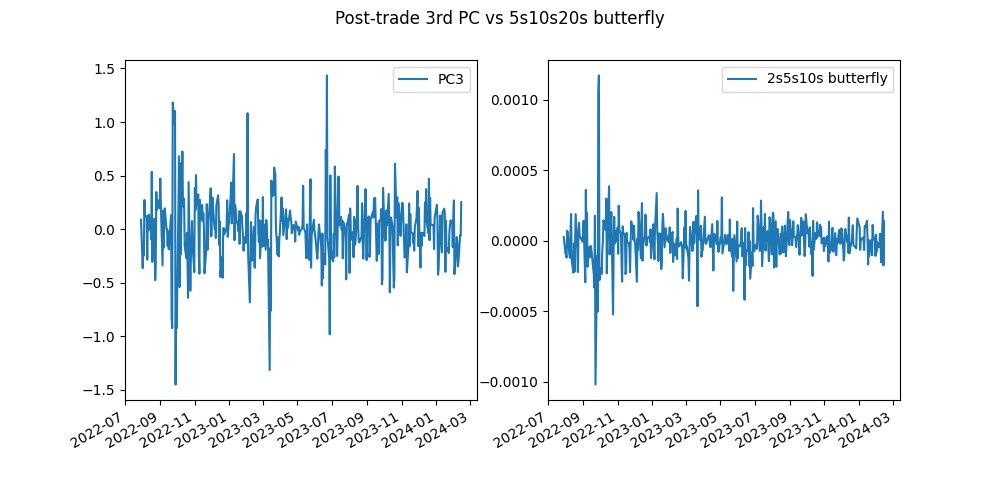

In [21]:
# 3rd PC
PC3 = post_trade_scales.dot(eigenvectors[:,2])
print(f"correlation between PC3 and 5s10s20s butterfly: {np.corrcoef(PC3, post_trade_butterfly)[0][1]}")
print(f"correlation between PC3 and 5-10 spread: {np.corrcoef(PC3, -post_trade_spread)[0][1]}")
print(f"correlation between PC3 and pnl: {np.corrcoef(PC3, pnl_series)[0][1]}")
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(post_trade_dates,PC3, label='PC3')
plt.gcf().autofmt_xdate()
plt.legend()
plt.subplot(1,2,2)
plt.plot(post_trade_dates,post_trade_butterfly, label='2s5s10s butterfly')
plt.gcf().autofmt_xdate()
plt.legend()

# a super title
plt.suptitle('Post-trade 3rd PC vs 5s10s20s butterfly')

In the first 6m, we find that the 2nd PC show strong correlation with the 2s5s10s curvature, which is why we decided to put on a short 2s5s10s butterfly trade after 6m. However, we find that the principle components relationship have shifted after trade date, especially the 2nd PC no longer exhibit strong correlation with the 2s5s10s curvature, which is why our PNL series doesn't exhibit strong correlation with the curvature.